In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import caffe
from google.protobuf import text_format

# configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Load the pretrained model

The model has been pretrained using Caffe framework during 40 epochs (20.000 iterations of training with a batchsize of 100 samples and 50.000 MNIST images).

In [2]:
caffe.set_mode_cpu()
model_path = 'models'
model_name = 'small'
path = os.path.join(model_path,model_name)

net_fn   = os.path.join(model_path, model_name, 'deploy.prototxt')
param_fn = os.path.join(model_path, model_name, '{}_iter_20000.caffemodel'.format(model_name))

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn, caffe.TEST)

# Summary

Here we print a summary of the network's architecture: 
* the layers
* the feature maps at each layer with their corresponding size
* the parameters with their minimum and maximi value per layer (without the biases).

In [3]:
def network_summary(net):
    """
    Returns a string with a summary of the specified network
    """
    string = "Architecture of {} network\n---------------------".format(model_name)
    for layer in net.layers:
        string += "\n" + layer.type

    string += "\n\nFeature map sizes (Blobs)\n-------------------------"
    for layer in net.blobs.keys():
        string += "\n{} = \t{}".format(layer, net.blobs[layer].data.shape)

    string += "\n\nParameter shape\n---------------"
    for layer in net.params.keys():
        string += "\n{} = {} \t(min,max) = ({:.2f},{:.2f})".format(
                layer, net.params[layer][0].data.shape,
                net.params[layer][0].data.min(), 
                net.params[layer][0].data.max())
    string += "\n"
    return string

def print_network_summary(net):
    """
    Prints the summary of the specified network
    """
    print network_summary(net)
    
print_network_summary(net)

Architecture of small network
---------------------
Dropout
Convolution
ReLU
Pooling
Convolution
ReLU
InnerProduct
Softmax

Feature map sizes (Blobs)
-------------------------
data = 	(1, 1, 24, 24)
conv1 = 	(1, 9, 20, 20)
pool1 = 	(1, 9, 10, 10)
conv2 = 	(1, 16, 6, 6)
ip1 = 	(1, 10)
prob = 	(1, 10)

Parameter shape
---------------
conv1 = (9, 1, 5, 5) 	(min,max) = (-0.81,1.45)
conv2 = (16, 9, 5, 5) 	(min,max) = (-0.43,0.49)
ip1 = (10, 576) 	(min,max) = (-0.46,0.48)



# We can visualize all the weights of the network

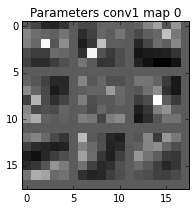

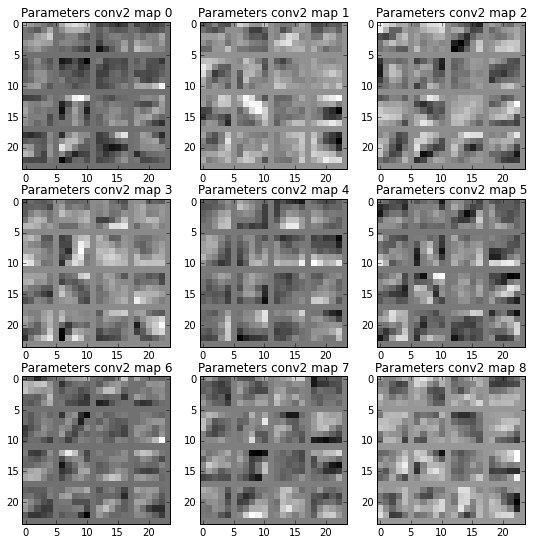

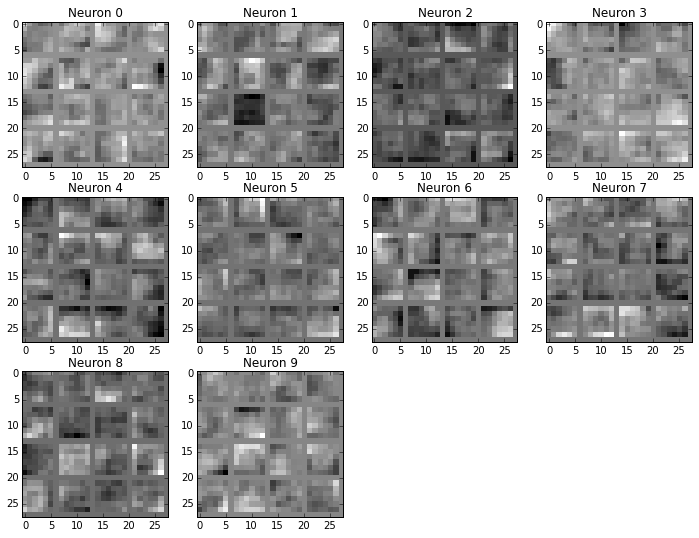

In [4]:
from math import ceil

def vis_square(data, padsize=1, padval=0):
    '''take an array of shape (n, height, width) or (n, height, width, channels)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    '''
    filt_min, filt_max = data.min(), data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data, vmin=filt_min, vmax=filt_max)

# helper show filters
def show_filters(net, layer='conv'):
    
    n_dimensions = len(net.params[layer][0].data.shape)
    if n_dimensions == 4:      # Convolution layer
        n_feature_maps = net.params[layer][0].data.shape[1]
        height = ceil(np.sqrt(n_feature_maps))
        figure_size = (x*height for x in plt.rcParams['figure.figsize'])
        fig = plt.figure(figsize=figure_size)
        for i in range(n_feature_maps):
            plt.subplot(height,height,i+1)
            vis_square(np.squeeze(net.params[layer][0].data[:,i,:,:]))
            plt.title('Parameters {} map {}'.format(layer, i))
    elif n_dimensions == 2:    # Fully connected layer
        index = net.blobs.keys().index(layer)
        prev_layer = net.blobs.keys()[index-1]
        input_shape = net.blobs[prev_layer].data.shape
        n_input_dimensions = len(input_shape)
        if n_input_dimensions == 4:   # From a Convolution layer
            n_neurons = net.params[layer][0].data.shape[0]
            height = ceil(np.sqrt(n_neurons))
            figure_size = (x*height for x in plt.rcParams['figure.figsize'])
            fig = plt.figure(figsize=figure_size)
            for i in range(n_neurons):
                plt.subplot(height,height,i+1)
                vis_square(np.squeeze(net.params[layer][0].data[i,:].reshape(input_shape)))
                plt.title("Neuron {}".format(i))
        elif n_input_dimensions == 2:  # From a Fully connected layer
            raise TypeError('Visualization of two fully connected layers not implemented')
    
    plt.show()
    return fig

for layer in net.params.keys():
    try:
        fig = show_filters(net, layer=layer)
    except ValueError:
        print("ValueError : {}".format(layer))
        pass
    except TypeError as e:
        print("TypeError in {} : {}".format(layer, e))
        pass

# Load a handwritten digit

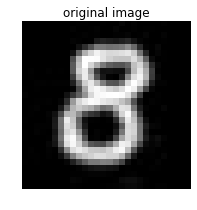

In [5]:
# load image and prepare as a single input batch for Caffe
im = np.array(Image.open('images/mnist_8.jpg'))
plt.title("original image")
plt.imshow(im)
plt.axis('off')

im_input = im[np.newaxis, np.newaxis, :, :]
# Adjust the size of the image to the expected size for the network
def crop(image,width):
    diff = image.shape[-1]-width
    if diff == 0:
        return image
    else:
        return image[0,0,diff/2:-diff/2,diff/2:-diff/2].reshape(1,1,width,width)
    
net.blobs['data'].data[...] = crop(im_input,net.blobs['data'].data.shape[-1])

# Forward propagate

Now we can give the image as an input, and forward propagate it trough all the network.
Then we can retrieve the hidden activations at each layer

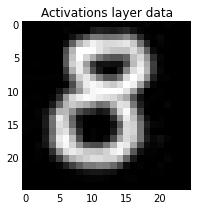

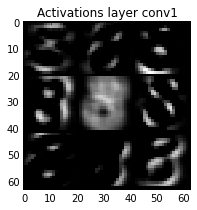

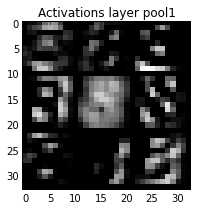

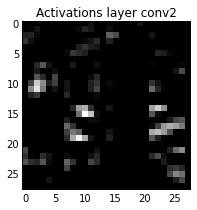

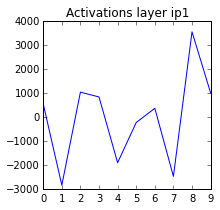

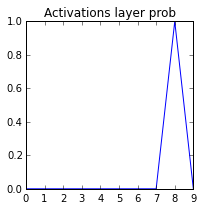

In [6]:
from collections import OrderedDict

def get_hidden_activations(net, image):
    im_input = image[np.newaxis, np.newaxis, :, :]
    net.blobs['data'].data[...] = crop(im_input,net.blobs['data'].data.shape[-1])
    net.forward()
    return OrderedDict([(name, np.copy(net.blobs[name].data)) for name in net.blobs.keys()])

hidden_activations = get_hidden_activations(net, im)

# Show the activation values at each layer
for layer in net.blobs.keys():
    fig = plt.figure()
    if len(hidden_activations[layer].shape) > 2:
        vis_square(hidden_activations[layer][0,:])
    else:
        plt.plot(hidden_activations[layer].flatten())
    plt.title('Activations layer {}'.format(layer))

# Backpropagation

It should be possible to backpropagate the error from the last layer by computing the cross-entropy error on the soft-max layer. However, it is also possible to visualize the gradient at each layer that maximize one specific neuron $i$ of the network. As an example, we can look at the most active neuron $i$ of the second convolution and introduce as an error zero for all the neurons that we do not want to maximize $(\forall h_j \in Conv2 | j \neq i \to error(h_j) = 0)$, and the neuron $i$ that we want to maximize to its double $(error(h_i) = 2*h_i - h_i = h_i)$.

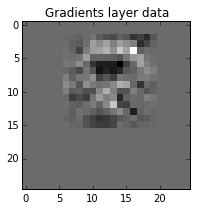

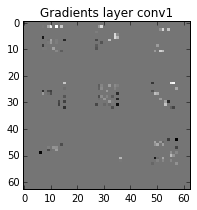

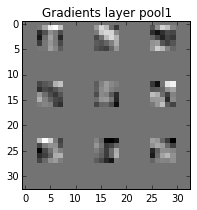

In [7]:
from collections import OrderedDict

def get_backward_gradients(net, image, end, neuron_coordinates=None, most_active=False):
    dst = net.blobs[end]
    
    im_input = image[np.newaxis, np.newaxis, :, :]
    net.blobs['data'].data[...] = crop(im_input,net.blobs['data'].data.shape[-1])
    
    net.forward(end=end)
    
    if neuron_coordinates:
        diff = np.zeros_like(dst.data)
        diff[neuron_coordinates] = 1
    elif most_active:
        neuron_coordinates = np.unravel_index(net.blobs[end].data.argmax(),net.blobs[end].data.shape)
        diff = np.zeros_like(dst.data)
        diff[neuron_coordinates] = 1
    else:
        diff = dst.data
        
    dst.diff[:] = diff
    
    net.backward(start=end)
    gradients = OrderedDict()
    for layer in net.blobs.keys():
        if layer != end:
            gradients.update({layer : np.copy(net.blobs[layer].diff[0])})
        else:
            break
    return gradients

end = 'conv2'
most_active=True
gradients = get_backward_gradients(net, im, end=end, most_active=most_active)

# Show the gradients at each layer
for layer in gradients.keys():
    fig = plt.figure()
    vis_square(gradients[layer])
    plt.title('Gradients layer {}'.format(layer))

It is also possible to give as an error for a layer exactly the same activation. With this idea we tell to the network that whatever the network creates, we want to maximize it. Then we can visualize the gradients in all the previous layers up to the input image

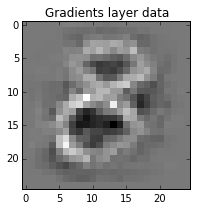

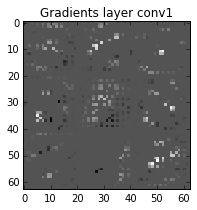

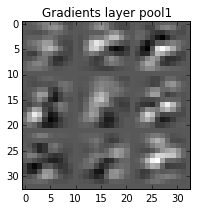

In [8]:
end = 'conv2'
most_active=False
gradients = get_backward_gradients(net, im, end=end, most_active=most_active)

for layer in gradients.keys():
    fig = plt.figure()
    vis_square(gradients[layer])
    plt.title('Gradients layer {}'.format(layer))

# Export network summary
The next lines of code create and save all the previous images and summary information about the network. The weights, and the activations of each layer given the previous image.

In [9]:
import time

def export_plot(fig,filename,path='',format='pdf',date=True):
    """
    Exports the figure into the project folder
    suported formats : eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff.
    """
    if date:
        formated_filename = os.path.join(path, "{0}{1}.{2}".format(time.strftime("%Y%m%d_%H%M%S"), filename, format))
    else:
        formated_filename = os.path.join(path,"{0}.{1}".format(filename, format))
    fig.savefig(formated_filename, format=format)

def save_network_summary(net, path, sample_image=[]):
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'summary.txt'), "w") as text_file:
        text_file.write(network_summary(net))
    # filter the image with initial
    for layer in net.params.keys():
        try:
            fig = show_filters(net, layer=layer)
            filename = layer + '_filters'
            export_plot(fig,filename=filename,path=path,format='pdf',date=False)
        except ValueError:
            print("ValueError : {}".format(layer))
            pass
        except TypeError as e:
            print("TypeError in {} : {}".format(layer, e))
            pass
    
    if sample_image != []:
        hidden_activations = get_hidden_activations(net, sample_image)
        for layer in net.blobs.keys():
            fig = plt.figure()
            if len(hidden_activations[layer].shape) > 2:
                vis_square(hidden_activations[layer][0,:])
            else:
                plt.plot(hidden_activations[layer].flatten())
            plt.title('Activations layer {}'.format(layer))
            filename = layer + '_activation'
            export_plot(fig,filename=filename,path=path,format='pdf',date=False)

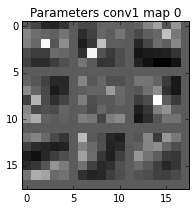

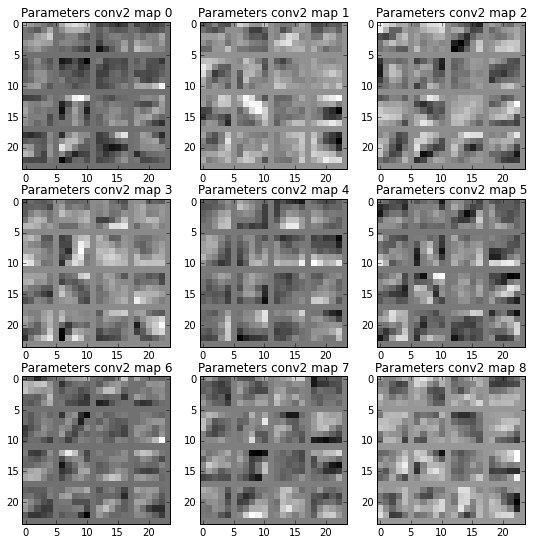

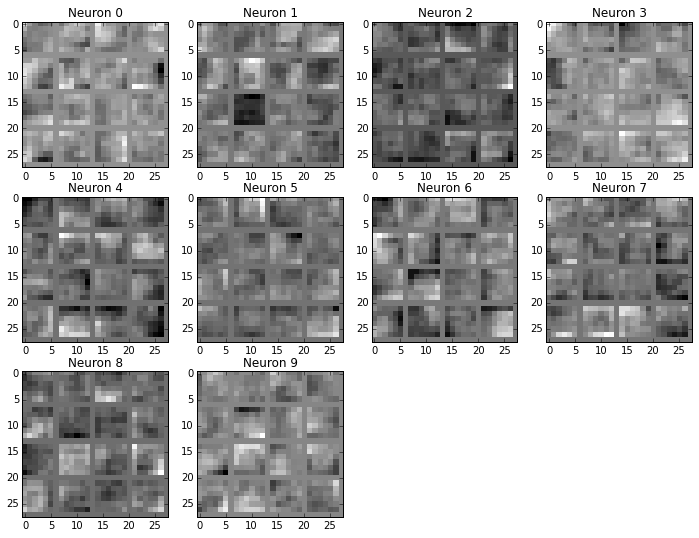

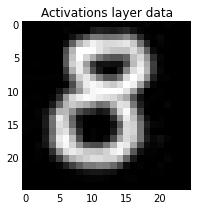

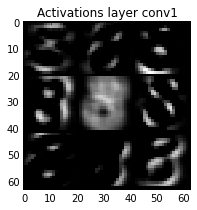

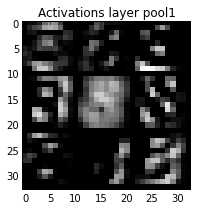

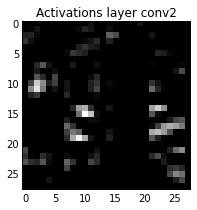

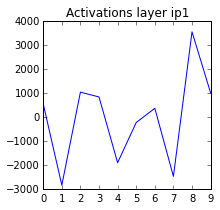

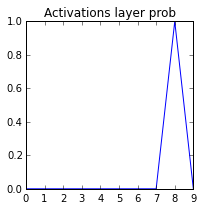

In [10]:
path = os.path.join(model_path,model_name,'summary')
save_network_summary(net, path, sample_image=im)

# export the gradients

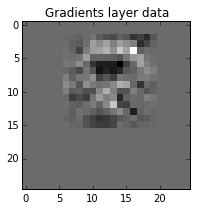

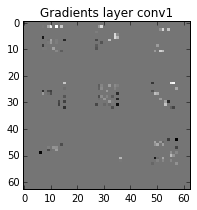

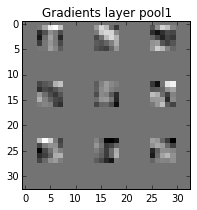

In [11]:
end = 'conv2'
most_active=True
gradients = get_backward_gradients(net, im, end=end, most_active=most_active)

for layer in gradients.keys():
    fig = plt.figure()
    vis_square(gradients[layer])
    plt.title('Gradients layer {}'.format(layer))
    filename = layer + '_most_active_gradients'
    export_plot(fig,filename=filename,path=path,format='pdf',date=False)

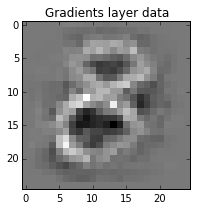

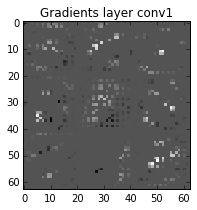

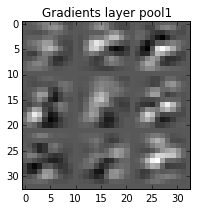

In [12]:
end = 'conv2'
most_active=False
gradients = get_backward_gradients(net, im, end=end, most_active=most_active)

for layer in gradients.keys():
    fig = plt.figure()
    vis_square(gradients[layer])
    plt.title('Gradients layer {}'.format(layer))
    filename = layer + '_gradients'
    export_plot(fig,filename=filename,path=path,format='pdf',date=False)